In [41]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
from scipy.stats import binom 
from datetime import datetime


# Function

In [42]:

def count_accu(K,df):
    count = 0
    for i in range(K): #first k row
        if df.iloc[i,-1] == df.iloc[i,-2]: # check y_pred and y_true
            count+=1
    for i in range(K): #last k row
        if df.iloc[-(i+1),-1]== df.iloc[-(i+1),-2]: 
            count+=1
    return count


def count_precision(K,df):
    count = 0
    for i in range(K): #first k row
        if df.iloc[i,-1] == df.iloc[i,-2]: # check y_pred and y_true
            count+=1
    return count

def classification(y):
    """
    function for classifying which class
    """
    if y >=0.5:
        return 1.0
    else:
        return 0.0
    
    
def binom_test(k, acc):
    n = 1250*k*2
    p = acc
    r = range(0,n+1)
    prob = binom.pmf(r, n, p)
    acc_50 = prob[n//2]
    print(acc_50)


def performance_test(file_name):
    
    """
    function for calculating accuracy and k
    file name: csv prediction file without .csv
    """
    date_list = []  
    sec_dict = {}
    data= pd.DataFrame()
    csv_file =str(file_name) +'.csv'
    data = pd.read_csv(csv_file)
    
    data['y_pred'] = data['y_prob'].apply(classification)
    a = data.groupby(by = ['Date']).count().reset_index()
    print("Number of rows less than 20 stocks: " , len(a[a['Ticker'] <=20])) 
    a = a.drop(a[a['Ticker'] <= 20].index)
    data = data.sort_values(['Date','y_prob'],ascending = True)
    date_list = list(a.Date.unique())
    data = data[['Date','Ticker','Sector','y_prob','y_pred','y_true']]
    data = data.reset_index(drop = True)
    print("completed classifcation for: "+file_name)

    date_accu_dict={}
    date_precision_dict={}
    K = [2, 4, 5, 8, 10,15]
    for k in K:
        accuracy_list = []
        precision_list = []
        for date in date_list:            
            data_date = data[data.Date == date]
            data_date = data_date.reset_index(drop = True)
            accu_item = count_accu(k,data_date) # how many item are correctly classified
            accuracy_date = accu_item/(2*k) # total accuracy per date
            accuracy_list.append(accuracy_date)
            date_accu_dict.update({date: accuracy_date}) # date: accuracy per date
            precision_item = count_precision(k,data_date)
            precision_date = precision_item/k
            precision_list.append(precision_date)
            date_precision_dict.update({date:precision_date})
        accuracy = round(sum(accuracy_list)/len(accuracy_list),4) 
        precision = round(sum(precision_list)/len(precision_list),4)
        if k == 10:
            overall_accuracy = accuracy
            overall_precision = precision
        print('Overall accuracy for K = '+str(k)+' is '+str(accuracy))
        print('Binomial Test Result: ')
        binom_test(k, accuracy)
        print('Overall Precision for K = '+str(k)+' is '+str(precision))
        print("===============================")

    # cal average acc per year
    acc_date= pd.DataFrame.from_dict(date_accu_dict,orient='index')
    acc_date.index = pd.to_datetime(acc_date.index)
    acc_date['year']=acc_date.index.year
    average_accuracy_per_year = acc_date.groupby('year').mean()
    print(average_accuracy_per_year)
    
    
    return data, date_list


In [43]:
def rebalance_freq(ds_1,ds_2):
    """
    function for dailying buying or selling the assets

    """
    
    ds = pd.concat([ds_1,ds_2],axis = 0,ignore_index = True).reset_index(drop = True)
    unique_length = len(ds.value_counts().keys().tolist()) #check the non-overlapping part
    non_unique = ds.size- unique_length
    rebalance_percentage = (ds_1.size-non_unique)/(ds_1.size) # percentage of stock that need to pay transaction cost
    return rebalance_percentage



def cal_return_equal(file_name):
    """
    function for calulate the return
    file name: only csv file name without .csv extension
    """

    df, date_list = performance_test(file_name)
    return_info = pd.read_csv("stock_analysis.csv")
    return_info = return_info[['Date','Ticker','daily_return']]
    return_info.columns = ['Date','Ticker','Price_Return']

    profit_nocost = {}
    accuprofit_nocost = {}
    nocost_accu_profit = 1 #100%
    short_accu_profit = 1
    long_accu_profit = 1

    profit_cost = {}
    accuprofit_cost = {}
    cost_accu_profit = 1

    for date in date_list[:-1]: # no next day information for rebalancing
        data_date = df[df.Date == date]
        long_part = data_date.iloc[-10:] # for each day, long the highest prob 
        short_part = data_date.iloc[:10] # for each day, short the lowest prob
        long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        short_df = short_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        long_daily_profit = long_df['Price_Return'].mean()
        short_daily_profit = (-1)*(short_df['Price_Return'].mean())
        daily_profit = (long_daily_profit + short_daily_profit)
        nocost_accu_profit += daily_profit
        short_accu_profit +=short_daily_profit
        long_accu_profit +=long_daily_profit

        profit_nocost.update({date:daily_profit}) # daily profit
        accuprofit_nocost.update({date:nocost_accu_profit}) # cumulative profit 

        date_index = date_list.index(date)
        long_part_next = df[df.Date == date_list[date_index+1]].iloc[-10:] # highest prob to outperform
        short_part_next = df[df.Date == date_list[date_index+1]].iloc[:10] # lowest prob to outperform

        ds_1 = long_part['Ticker']
        ds_2 = long_part_next['Ticker']
        ds_3 = short_part['Ticker']
        ds_4 = short_part_next['Ticker']

        # each transaction: 0.5% for half way trading
        # transaction only costs those short/buy
        daily_profit_cost = daily_profit - 0.005*((rebalance_freq(ds_1,ds_2)+rebalance_freq(ds_3,ds_4)))
        cost_accu_profit += daily_profit_cost 
        profit_cost.update({date:daily_profit_cost}) #daily profit w cost
        accuprofit_cost.update({date:cost_accu_profit}) #cum profit w cost

        
    # daily return
    long_return = (long_accu_profit - 1)/(len(date_list)-1)
    short_return = (short_accu_profit-1)/(len(date_list)-1)
    nocost_return = (nocost_accu_profit - 1)/(len(date_list)-1)
    nocost_sd = statistics.stdev(profit_nocost.values())
    cost_return = (cost_accu_profit - 1)/(len(date_list)-1)
    cost_sd = statistics.stdev(profit_cost.values())
    mean_return = statistics.mean(list(profit_nocost.values()))
    sharpe_ratio = mean_return / nocost_sd
    print("mean return: " + str(mean_return))
    print("SD: " + str(nocost_sd))
    print("sharpe ratio:" + str(sharpe_ratio))
    print("Profit: " + str(nocost_return))



    return_dict  = {'Model':file_name ,'Long Return':long_return, 'Short Return':short_return,'No Cost Return':nocost_return,'No Cost SD':nocost_sd, 'Cost Return':cost_return,'Cost SD':cost_sd}

    # write to csv
    # Mean return
    mean_return_file =file_name+'_return_summary_equal.csv'
    with open(mean_return_file,'w',newline='') as file:
        reader =csv.reader(mean_return_file)
        writer = csv.DictWriter(file, return_dict.keys())
        writer.writeheader()
        writer.writerow(return_dict)

    print('Mean Return file Saved to '+mean_return_file)


    # return by date 
    daily_return_file=file_name+'_daily_return_summary_equal.csv'
    df1 = pd.DataFrame.from_dict(profit_nocost,orient='index', columns=['daily_return_no_cost'])
    df2 = pd.DataFrame.from_dict(accuprofit_nocost,orient='index', columns=['cum_return_no_cost'])
    df3 = pd.DataFrame.from_dict(profit_cost,orient='index', columns=['daily_return_cost'])
    df4 = pd.DataFrame.from_dict(accuprofit_cost,orient='index', columns=['cum_return_cost'])

    merge_return= df1.join(df2).join(df3).join(df4) 
    merge_return.to_csv(daily_return_file)
    print('Return by Date file Saved to '+daily_return_file)

    

    print('Complete')


In [44]:
def performance_test_short(file_name):
    
    """
    function to create the same output as previous
    but without testing different k and just produce output directly
    file name: csv prediction file without .csv
    """
    date_list = []  
    sec_dict = {}
    data= pd.DataFrame()
    csv_file =file_name +'.csv'
    data = pd.read_csv(csv_file)
    
    data['y_pred'] = data['y_prob'].apply(classification)
    a = data.groupby(by = ['Date']).count().reset_index()
    print("Number of rows less than 20 stocks: " , len(a[a['Ticker'] <= 20])) 
    a = a.drop(a[a['Ticker'] <= 20].index)
    data = data.sort_values(['Date','y_prob'],ascending = True)
    date_list = list(a.Date.unique())
    data = data[['Date','Ticker','Sector','y_prob','y_pred','y_true']]
    data = data.reset_index(drop = True)
    print("completed classifcation for: "+file_name)
        
    
    return data, date_list




# long 130, short 30
def cal_return_13030(file_name):
    """
    function for calulate the return
    file name: only csv file name without .csv extension
    """

    df, date_list = performance_test_short(file_name)
    return_info = pd.read_csv("stock_analysis.csv")
    return_info = return_info[['Date','Ticker','daily_return']]
    return_info.columns = ['Date','Ticker','Price_Return']

    profit_nocost = {}
    accuprofit_nocost = {}
    nocost_accu_profit = 1 #100%
    short_accu_profit = 1
    long_accu_profit = 1

    profit_cost = {}
    accuprofit_cost = {}
    cost_accu_profit = 1

    for date in date_list[:-1]: # no next day information for rebalancing
        data_date = df[df.Date == date]
        long_part = data_date.iloc[-8:] # for each day, long the highest prob 
        short_part = data_date.iloc[:8] # for each day, short the lowest prob
        long_df = long_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        short_df = short_part.merge(return_info,how ='left',on = ['Date','Ticker'])
        long_daily_profit = long_df['Price_Return'].mean()
        short_daily_profit = (-1)*(short_df['Price_Return'].mean())
        daily_profit = (1.3*long_daily_profit + 0.3*short_daily_profit)
        nocost_accu_profit += daily_profit
        short_accu_profit +=short_daily_profit
        long_accu_profit +=long_daily_profit

        profit_nocost.update({date:daily_profit}) # daily profit
        accuprofit_nocost.update({date:nocost_accu_profit}) # cumulative profit 

        date_index = date_list.index(date)
        long_part_next = df[df.Date == date_list[date_index+1]].iloc[-10:] # highest prob to outperform
        short_part_next = df[df.Date == date_list[date_index+1]].iloc[:10] # lowest prob to outperform

        ds_1 = long_part['Ticker']
        ds_2 = long_part_next['Ticker']
        ds_3 = short_part['Ticker']
        ds_4 = short_part_next['Ticker']

        # each transaction: 0.05% for half way trading
        # transaction only costs those short/buy
        daily_profit_cost = daily_profit - 0.005*((1.3*rebalance_freq(ds_1,ds_2)+0.3*rebalance_freq(ds_3,ds_4)))
        cost_accu_profit += daily_profit_cost 
        profit_cost.update({date:daily_profit_cost}) #daily profit w cost
        accuprofit_cost.update({date:cost_accu_profit}) #cum profit w cost
        #print(date)
        
    # daily return
    long_return = (long_accu_profit - 1)/(len(date_list)-1)
    short_return = (short_accu_profit-1)/(len(date_list)-1)
    nocost_return = (nocost_accu_profit - 1)/(len(date_list)-1)
    nocost_sd = statistics.stdev(profit_nocost.values())
    cost_return = (cost_accu_profit - 1)/(len(date_list)-1)
    cost_sd = statistics.stdev(profit_cost.values())
    mean_return = statistics.mean(list(profit_nocost.values()))
    sharpe_ratio = mean_return / nocost_sd
    print("mean return: " + str(mean_return))
    print("SD: " + str(nocost_sd))
    print("sharpe ratio:" + str(sharpe_ratio))
    print("Profit: " + str(nocost_return))



    return_dict  = {'Model':file_name ,'Long Return':long_return, 'Short Return':short_return,'No Cost Return':nocost_return,'No Cost SD':nocost_sd, 'Cost Return':cost_return,'Cost SD':cost_sd}

    # write to csv
    # Mean return
    mean_return_file =file_name+'_return_summary130_30.csv'
    with open(mean_return_file,'w',newline='') as file:
        reader =csv.reader(mean_return_file)
        writer = csv.DictWriter(file, return_dict.keys())
        writer.writeheader()
        writer.writerow(return_dict)

    print('Mean Return file Saved to '+mean_return_file)

    # return by date 
    daily_return_file=file_name+'_daily_return_summary_13030.csv'
    df1 = pd.DataFrame.from_dict(profit_nocost,orient='index', columns=['daily_return_no_cost'])
    df2 = pd.DataFrame.from_dict(accuprofit_nocost,orient='index', columns=['cum_return_no_cost'])
    df3 = pd.DataFrame.from_dict(profit_cost,orient='index', columns=['daily_return_cost'])
    df4 = pd.DataFrame.from_dict(accuprofit_cost,orient='index', columns=['cum_return_cost'])

    merge_return= df1.join(df2).join(df3).join(df4) 
    merge_return.to_csv(daily_return_file)
    print('Return by Date file Saved to '+daily_return_file)



    print('Complete')

# 1.Accuracy Check

In [45]:
# RF
# final result here

combined_data = pd.DataFrame()

for i in range(5):  
    data = pd.read_csv('/DAX/3_RF/rf_pred/rf_pred_'+str(i)+'.csv')
    combined_data = pd.concat([combined_data,data], ignore_index=True)
combined_data.to_csv('rf_prediction.csv', index=False)


import csv
cal_return_equal('rf_prediction')
cal_return_13030('rf_prediction')

Number of rows less than 20 stocks:  0
completed classifcation for: rf_prediction
Overall accuracy for K = 2 is 0.5078
Binomial Test Result: 
0.006140113875618783
Overall Precision for K = 2 is 0.5104
Overall accuracy for K = 4 is 0.5045
Binomial Test Result: 
0.005321484665931521
Overall Precision for K = 4 is 0.506
Overall accuracy for K = 5 is 0.5062
Binomial Test Result: 
0.0027295262939415156
Overall Precision for K = 5 is 0.505
Overall accuracy for K = 8 is 0.5067
Binomial Test Result: 
0.0009365488668137575
Overall Precision for K = 8 is 0.5066
Overall accuracy for K = 10 is 0.5038
Binomial Test Result: 
0.002451297612858141
Overall Precision for K = 10 is 0.5034
Overall accuracy for K = 15 is 0.503
Binomial Test Result: 
0.002097816419239669
Overall Precision for K = 15 is 0.5022
             0
year          
2012  0.498039
2013  0.494598
2014  0.505159
2015  0.505138
2016  0.503268
2017  0.507879
mean return: 0.014387292407846284
SD: 0.6117606660784937
sharpe ratio:0.023517844

In [46]:
# FNN

combined_data = pd.DataFrame()

for i in range(5):  
    data = pd.read_csv('/DAX/4_FNN/fnn_prediction/fnn_prediction_period_'+str(i)+'.csv')
    combined_data = pd.concat([combined_data,data], ignore_index=True)
combined_data.to_csv('fnn_prediction.csv', index=False)


import csv
cal_return_equal('fnn_prediction')
cal_return_13030('fnn_prediction')

Number of rows less than 20 stocks:  0
completed classifcation for: fnn_prediction
Overall accuracy for K = 2 is 0.4958
Binomial Test Result: 
0.009458474450935594
Overall Precision for K = 2 is 0.5056
Overall accuracy for K = 4 is 0.5004
Binomial Test Result: 
0.007953155270721128
Overall Precision for K = 4 is 0.505
Overall accuracy for K = 5 is 0.501
Binomial Test Result: 
0.006960156186558998
Overall Precision for K = 5 is 0.508
Overall accuracy for K = 8 is 0.5002
Binomial Test Result: 
0.0056328056086863264
Overall Precision for K = 8 is 0.5012
Overall accuracy for K = 10 is 0.5
Binomial Test Result: 
0.005046214581642209
Overall Precision for K = 10 is 0.5016
Overall accuracy for K = 15 is 0.5012
Binomial Test Result: 
0.0036984316176029877
Overall Precision for K = 15 is 0.5015
             0
year          
2012  0.500000
2013  0.502767
2014  0.507804
2015  0.504743
2016  0.492026
2017  0.498333
mean return: 0.01685463406461169
SD: 0.6796322425786897
sharpe ratio:0.024799638699

In [47]:
# LSTM
combined_data = pd.DataFrame()

for i in range(5):  
    data = pd.read_csv('/DAX/5_LSTM/lstm_prediction/lstm_prediction_period_'+str(i)+'.csv')
    combined_data = pd.concat([combined_data,data], ignore_index=True)
combined_data.to_csv('lstm_prediction.csv', index=False)


import csv
cal_return_equal('lstm_prediction')
cal_return_13030('lstm_prediction')

Number of rows less than 20 stocks:  0
completed classifcation for: lstm_prediction
Overall accuracy for K = 2 is 0.5106
Binomial Test Result: 
0.0036673332371487165
Overall Precision for K = 2 is 0.5256
Overall accuracy for K = 4 is 0.5076
Binomial Test Result: 
0.0025128944876921452
Overall Precision for K = 4 is 0.515
Overall accuracy for K = 5 is 0.5064
Binomial Test Result: 
0.002562845256028294
Overall Precision for K = 5 is 0.5152
Overall accuracy for K = 8 is 0.501
Binomial Test Result: 
0.005420605743874001
Overall Precision for K = 8 is 0.5105
Overall accuracy for K = 10 is 0.5025
Binomial Test Result: 
0.003691875033292561
Overall Precision for K = 10 is 0.5082
Overall accuracy for K = 15 is 0.5008
Binomial Test Result: 
0.003927130836685701
Overall Precision for K = 15 is 0.5051
             0
year          
2012  0.501961
2013  0.506719
2014  0.496296
2015  0.498946
2016  0.503922
2017  0.497576
mean return: 0.010580254385108082
SD: 0.6812455487278787
sharpe ratio:0.015530

In [48]:
# Transformer
combined_data = pd.DataFrame()

for i in range(5):  
    data = pd.read_csv('/DAX/6_Transformer/tf_prediction/tf_prediction_period_'+str(i)+'.csv')
    combined_data = pd.concat([combined_data,data], ignore_index=True)
combined_data.to_csv('tf_prediction.csv', index=False)


import csv
cal_return_equal('tf_prediction')
cal_return_13030('tf_prediction')

Number of rows less than 20 stocks:  0
completed classifcation for: tf_prediction
Overall accuracy for K = 2 is 0.5164
Binomial Test Result: 
0.0007651139534302806
Overall Precision for K = 2 is 0.5176
Overall accuracy for K = 4 is 0.5119
Binomial Test Result: 
0.0004694311209344802
Overall Precision for K = 4 is 0.5092
Overall accuracy for K = 5 is 0.5075
Binomial Test Result: 
0.0017485620034539484
Overall Precision for K = 5 is 0.5085
Overall accuracy for K = 8 is 0.5063
Binomial Test Result: 
0.0011531318781743665
Overall Precision for K = 8 is 0.5086
Overall accuracy for K = 10 is 0.5051
Binomial Test Result: 
0.0013744734574055093
Overall Precision for K = 10 is 0.507
Overall accuracy for K = 15 is 0.5014
Binomial Test Result: 
0.0035569682876444414
Overall Precision for K = 15 is 0.5009
             0
year          
2012  0.492157
2013  0.502767
2014  0.507407
2015  0.498024
2016  0.501046
2017  0.497727
mean return: 0.00642105297934347
SD: 0.6774570838126645
sharpe ratio:0.0094

In [49]:
# TCN

combined_data = pd.DataFrame()

for i in range(5):  
    data = pd.read_csv('/DAX/7_TCN/tcn_prediction/tcn_prediction_period_'+str(i)+'.csv')

    combined_data = pd.concat([combined_data,data], ignore_index=True)

combined_data.to_csv('tcn_prediction.csv', index=False)


import csv
cal_return_equal('tcn_prediction')
cal_return_13030('tcn_prediction')

Number of rows less than 20 stocks:  0
completed classifcation for: tcn_prediction
Overall accuracy for K = 2 is 0.5126
Binomial Test Result: 
0.002305305077518719
Overall Precision for K = 2 is 0.5112
Overall accuracy for K = 4 is 0.5098
Binomial Test Result: 
0.0011683584139218874
Overall Precision for K = 4 is 0.5094
Overall accuracy for K = 5 is 0.5074
Binomial Test Result: 
0.0018149392751045782
Overall Precision for K = 5 is 0.5082
Overall accuracy for K = 8 is 0.5072
Binomial Test Result: 
0.0007092073291081612
Overall Precision for K = 8 is 0.5068
Overall accuracy for K = 10 is 0.5071
Binomial Test Result: 
0.0004057103585485065
Overall Precision for K = 10 is 0.5076
Overall accuracy for K = 15 is 0.5023
Binomial Test Result: 
0.0027708522823055243
Overall Precision for K = 15 is 0.5028
             0
year          
2012  0.537255
2013  0.505270
2014  0.501058
2015  0.500527
2016  0.505882
2017  0.495758
mean return: 0.008816884945076051
SD: 0.6484720686107552
sharpe ratio:0.01

In [ ]:
# accuracy data from previous part
# Data for DAX
dax_data = {
    'Model': ['LSTM', 'TCN', 'Transformer', 'FNN', 'RF'],
    'k=2': [0.51, 0.513, 0.52, 0.5, 0.51],
    'k=4': [0.508, 0.51, 0.512, 0.5, 0.506],
    'k=5': [0.506, 0.507, 0.508, 0.501, 0.506],
    'k=8': [0.501, 0.507, 0.506, 0.5, 0.507],
    'k=10': [0.503, 0.507, 0.505, 0.5, 0.508],
    'k=15': [0.501, 0.502, 0.501, 0.501, 0.507]
}

dax_df = pd.DataFrame(dax_data)
dax_df = dax_df.set_index('Model').T.reset_index()
dax_df.set_index('index', inplace=True)
dax_df

# 2.Financial Performance

In [40]:
# comparing the performance to market performance

file = pd.read_csv('/DAX/8_performance/stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-11-13')  ]

file['Date'] =pd.to_datetime(file['Date'])
file['year'] = file.Date.dt.year

overall_market_performance  = file.groupby(['year'])['daily_return'].mean().reset_index()
overall_market_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
overall_market_performance['model']='market'
overall_market_performance


,year,daily_return_no_cost,model
0,2012,0.030977,market
1,2013,0.092882,market
2,2014,0.024326,market
3,2015,0.061851,market
4,2016,0.027456,market
5,2017,0.082764,market


   year  daily_return_no_cost       model
0  2012              0.030977      market
1  2013              0.092882      market
2  2014              0.024326      market
3  2015              0.061851      market
4  2016              0.027456      market
5  2017              0.082764      market
0  2012             -0.035009    tf_equal
1  2013             -0.002649    tf_equal
2  2014              0.070121    tf_equal
3  2015             -0.042345    tf_equal
4  2016              0.035706    tf_equal
5  2017             -0.030944    tf_equal
0  2012              0.140882   tcn_equal
1  2013             -0.006931   tcn_equal
2  2014              0.008292   tcn_equal
3  2015             -0.029630   tcn_equal
4  2016              0.074609   tcn_equal
5  2017             -0.014829   tcn_equal
0  2012              0.080237  lstm_equal
1  2013              0.103591  lstm_equal
2  2014             -0.023429  lstm_equal
3  2015             -0.035458  lstm_equal
4  2016             -0.041291  lst

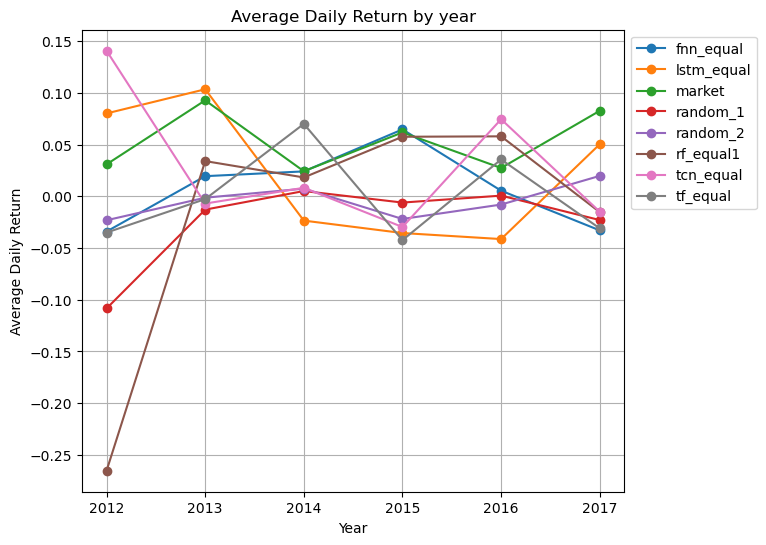

In [10]:
# yearly 

# for each model, read csv and add it to the dataframe
read_csv_dict={
    'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
    ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
           ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
                 ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'

              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return['date'] =pd.to_datetime(mean_return['date'])
    mean_return['year'] = mean_return.date.dt.year
    mean_return = mean_return[['year','daily_return_no_cost']]
    mean_return = mean_return.groupby('year')['daily_return_no_cost'].mean(numeric_only=True).reset_index()
    mean_return['model']=file
    #mean_return = mean_return[['model','year','daily_return_no_cost']]
    summary_return = pd.concat([mean_return,summary_return])
    
    
    
file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03') & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year'] = file.Date.dt.year

# choose randomly
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

    
portfolio_performance  = portfolio.groupby(['year'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance['model']='random_1'
portfolio_performance

portfolio2 = pd.DataFrame()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=60) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=25) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio2 = pd.concat([portfolio2,long_file, short_file])    

    
portfolio_performance2  = portfolio2.groupby(['year'])['daily_return'].mean().reset_index()
portfolio_performance2.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance2['model']='random_2'
portfolio_performance2

summary_return =pd.concat([overall_market_performance,summary_return, portfolio_performance, portfolio_performance2])
print(summary_return)

df = summary_return.groupby(['year','model']).mean().reset_index()
df = df.pivot(index='year',columns='model',values='daily_return_no_cost').reset_index()
df

# Average Daily Return by year

plt.figure(figsize=(7,6))

for column in df.columns:
    if column !='year':
        plt.plot(df['year'],df[column],label=column, marker='o')
        
plt.title('Average Daily Return by year')
plt.xlabel('Year')
plt.ylabel('Average Daily Return')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True)

plt.show()

In [ ]:
5119# year month average return

# for each model, read csv and add it to the dataframe
read_csv_dict={ 'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
          ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'

              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return['date'] =pd.to_datetime(mean_return['date'])
    mean_return['year_month'] = mean_return.date.dt.strftime('%y/%m')
    mean_return['model']=file
    mean_return = mean_return[['model','year_month','daily_return_no_cost']]
    mean_return  = mean_return.groupby(['model','year_month'])['daily_return_no_cost'].mean().reset_index()

    summary_return = pd.concat([mean_return,summary_return])


    
#########################
# comparing the performance to market performance

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03') & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    
    
portfolio_performance  = portfolio.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance['model']='random_1'


# Portfolio3
portfolio3 = pd.DataFrame()

long_profit = pd.DataFrame()
short_profit= pd.DataFrame()

longlist = file['Ticker'].sample(n=10, random_state=60).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=25).to_list()

for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_profit=pd.concat([long_file,long_profit])

for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])

portfolio3 = pd.concat([long_profit, short_profit])    

portfolio_performance3  = portfolio3.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance3.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance3['model']='random_2'



summary_return =pd.concat([summary_return,portfolio_performance,portfolio_performance3])

df2 = summary_return.pivot(index='year_month',columns='model',values='daily_return_no_cost').reset_index()


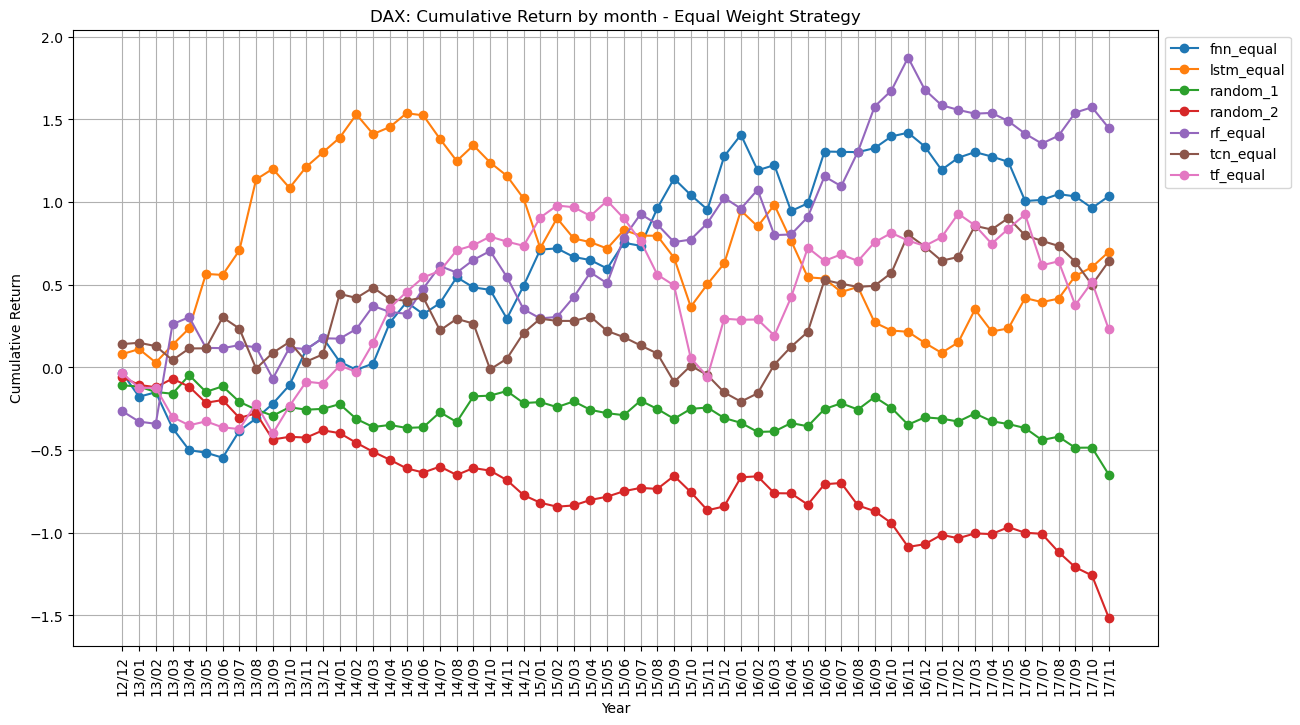

In [12]:
# cum return Prep data
df3 =summary_return.copy()
df3['cum_return']=df3.groupby(['model'])['daily_return_no_cost'].cumsum()
df3 = df3.sort_values(by='model', ascending=True)
df4 = df3.pivot(index='year_month',columns='model',values='cum_return').reset_index()
df4.dropna(inplace=True)

# cum return by month plot graoh
fig =plt.figure(figsize=(14,8))

for column in df4.columns:
    if column !='year_month':
        plt.plot(df4['year_month'],df4[column],label=column, marker='o')

plt.title('DAX: Cumulative Return by month - Equal Weight Strategy')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

plt.xticks(rotation=90)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True)

#plt.show()


In [13]:
fig.savefig('dax_equal_weight.png', dpi=100)

/tmp/ipykernel_182106/2501836109.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_file['daily_return'] = (1.3)*long_file['daily_return']
/tmp/ipykernel_182106/2501836109.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']


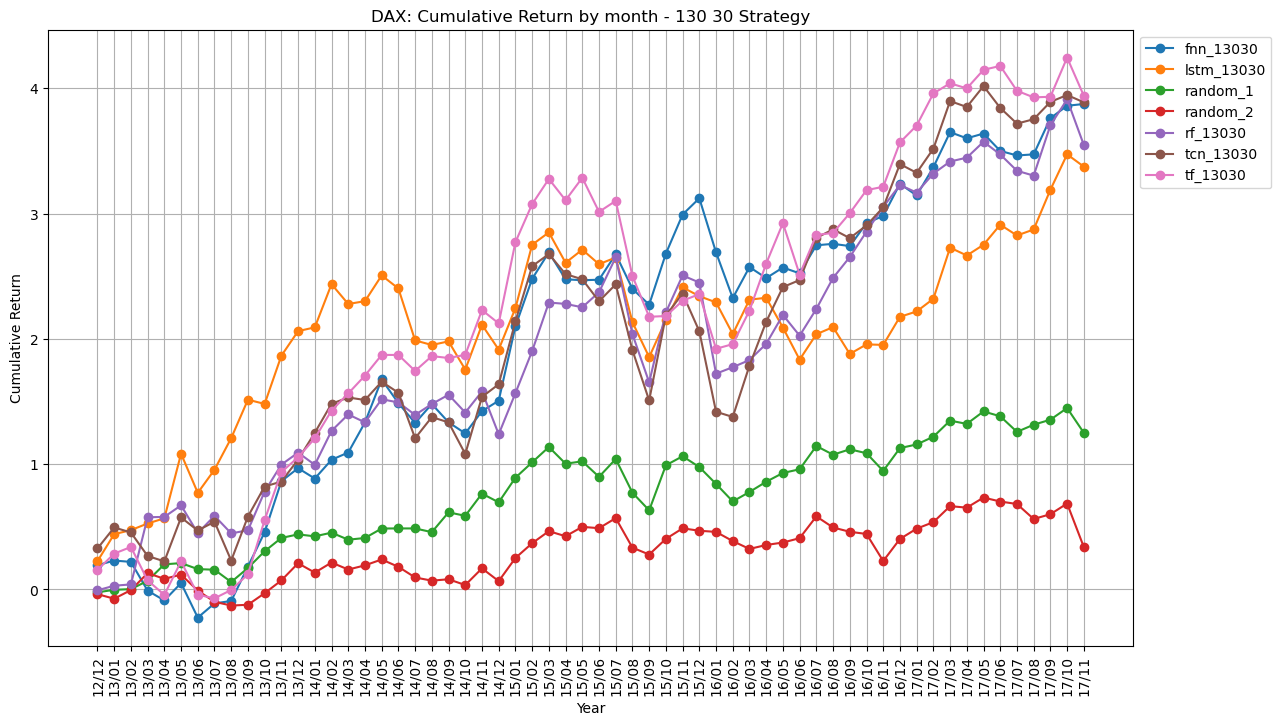

In [14]:
# 130 30 year month cum return

# for each model, read csv and add it to the dataframe
read_csv_dict={
             'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return['date'] =pd.to_datetime(mean_return['date'])
    mean_return['year_month'] = mean_return.date.dt.strftime('%y/%m')
    mean_return['model']=file
    mean_return = mean_return[['model','year_month','daily_return_no_cost']]
    mean_return  = mean_return.groupby(['model','year_month'])['daily_return_no_cost'].mean().reset_index()

    summary_return = pd.concat([mean_return,summary_return])


    
#########################
# comparing the performance to market performance

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03') & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

    
portfolio_performance  = portfolio.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance['model']='random_1'


# Portfolio2
portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()

longlist = file['Ticker'].sample(n=10, random_state=60).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=25).to_list()

for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    long_profit=pd.concat([long_file,long_profit])

for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])

portfolio3 = pd.concat([long_profit, short_profit])    

portfolio_performance3  = portfolio3.groupby(['year_month'])['daily_return'].mean().reset_index()
portfolio_performance3.rename(columns={'daily_return':'daily_return_no_cost'},inplace=True)
portfolio_performance3['model']='random_2'


summary_return =pd.concat([summary_return,portfolio_performance,portfolio_performance3])

df2 = summary_return.pivot(index='year_month',columns='model',values='daily_return_no_cost').reset_index()




# cum return Prep data
df3 =summary_return.copy()
df3['cum_return']=df3.groupby(['model'])['daily_return_no_cost'].cumsum()
df3 = df3.sort_values(by='model', ascending=True)
df4 = df3.pivot(index='year_month',columns='model',values='cum_return').reset_index()
df4.dropna(inplace=True)

# cum return by month plot graoh

fig  = plt.figure(figsize=(14,8))

for column in df4.columns:
    if column !='year_month':
        plt.plot(df4['year_month'],df4[column],label=column, marker='o')

plt.title('DAX: Cumulative Return by month - 130 30 Strategy')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=90)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.grid(True)

plt.show()


In [15]:
fig.savefig('dax_130-30.png')

### Risk Return Calculation

In [151]:
# annualiezed rate = (1+monthly rate)^12 -1
annual_rf = 1.008**(12)-1
annual_rf

0.10033869371614634

Market Random Portfolio

In [202]:

file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03') & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    
    
print(portfolio.daily_return.describe())
print('=========================')

portfolio['date'] =pd.to_datetime(portfolio['Date'])
portfolio['Year'] = portfolio['Date'].dt.year
#portfolio['exces_return'] = portfolio.daily_return -0.03
portfolio = portfolio.sort_values(by='Date')
portfolio

std_per_year = portfolio.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio.groupby(portfolio['Year'])['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']

print('Annaul Return')
print(annual_returns.mean())

print('=========================')

count    25000.000000
mean        -0.008120
std          1.566360
min        -14.532660
25%         -0.815436
50%         -0.000000
75%          0.804911
max         16.574839
Name: daily_return, dtype: float64
Annaul Return
Year             2014.500000
daily_return       -0.024033
excess_return      -0.124372
sd                  1.444930
sharpe_ratio       -0.096355
dtype: float64


In [203]:
## 130-30 market portfolio

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

print(portfolio.daily_return.describe())
print('Portfolio 1 Daily Return: 130-30')
print('=========================')


portfolio['date'] =pd.to_datetime(portfolio['Date'])
portfolio['Year'] = portfolio['Date'].dt.year
portfolio['exces_return'] = portfolio.daily_return -0.03
portfolio = portfolio.sort_values(by='Date')

std_per_year = portfolio.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio.groupby('Year')['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
print('annual return')
print(annual_returns.mean())
print('=========================')

count    25000.000000
mean         0.023815
std          1.492563
min        -18.892458
25%         -0.459376
50%          0.000000
75%          0.471952
max         21.547291
Name: daily_return, dtype: float64
Portfolio 1 Daily Return: 130-30
annual return
Year             2014.500000
daily_return        0.016499
excess_return      -0.083840
sd                  1.373159
sharpe_ratio       -0.066815
dtype: float64


In [207]:
# Portfolio2 equal weight


file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')


portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
longlist = file['Ticker'].sample(n=10, random_state=60).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=25).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_profit=pd.concat([long_file,long_profit])
for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])
portfolio3 = pd.concat([long_profit, short_profit])    

print(portfolio3[['daily_return']].describe(include =[float]))

print('=========================')
portfolio3['date'] =pd.to_datetime(portfolio3['Date'])
portfolio3['Year'] = portfolio3['Date'].dt.year
portfolio3['exces_return'] = portfolio3.daily_return -0.03
portfolio3 = portfolio3.sort_values(by='Date')
portfolio3

std_per_year = portfolio3.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio3.groupby(portfolio3['Year'])['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
print('Annual Return')
print(annual_returns.mean())

print('=========================')

       daily_return
count  22627.000000
mean      -0.023111
std        1.592620
min      -29.621343
25%       -0.824630
50%       -0.021734
75%        0.776814
max       29.621343
Annual Return
Year             2014.500000
daily_return       -0.028495
excess_return      -0.128834
sd                  1.470088
sharpe_ratio       -0.094984
dtype: float64


/tmp/ipykernel_182106/447991028.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (-1)*short_file['daily_return']


In [206]:
# Portfolio2 130-30 weight


file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')


portfolio3 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
longlist = file['Ticker'].sample(n=10, random_state=60).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=25).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    long_profit=pd.concat([long_file,long_profit])

for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])

portfolio3 = pd.concat([long_profit, short_profit])    

print(portfolio3[['daily_return']].describe(include =[float]))

print('=========================')
portfolio3['date'] =pd.to_datetime(portfolio3['Date'])
portfolio3['Year'] = portfolio3['Date'].dt.year
portfolio3['exces_return'] = portfolio3.daily_return -0.03
portfolio3 = portfolio3.sort_values(by='Date')
portfolio3

std_per_year = portfolio3.groupby('Year')['daily_return'].std().reset_index()
std_per_year.rename(columns={'daily_return':'sd'}, inplace=True)

annual_returns = portfolio3.groupby(portfolio3['Year'])['daily_return'].mean().reset_index()
annual_returns['excess_return'] =   annual_returns.daily_return -annual_rf
annual_returns = annual_returns.merge(std_per_year, on ='Year')
annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
print('Annual Return')
print(annual_returns.mean())

print('=========================')

       daily_return
count  22627.000000
mean       0.008290
std        1.441792
min      -32.059677
25%       -0.426953
50%       -0.009421
75%        0.414817
max       38.507745
Annual Return
Year             2014.500000
daily_return        0.001307
excess_return      -0.099032
sd                  1.327570
sharpe_ratio       -0.082794
dtype: float64


/tmp/ipykernel_182106/1764328880.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_file['daily_return'] = (1.3)*long_file['daily_return']
/tmp/ipykernel_182106/1764328880.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']


In [58]:
# Sharpe Ratio daily
# performance characteristic part 1
# without cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['excess_return'] = df.daily_return_no_cost -0.003
    #df['std_per_day'] = df.groupby('date')['daily_return_no_cost'].std().reset_index()
    
    
    df = df.sort_values(by='date')
    print("Model :", file)

    # Group by year and calculate total return for each year
    print(df[['daily_return_no_cost']].describe(include =[float]))
    print("=========================================================================")

    

Model : rf_equal
       daily_return_no_cost
count           1249.000000
mean               0.014387
std                0.611761
min               -2.467672
25%               -0.343787
50%                0.014171
75%                0.377323
max                3.230919
Model : rf_13030
       daily_return_no_cost
count           1249.000000
mean               0.068323
std                1.166188
min               -5.686198
25%               -0.538560
50%                0.086668
75%                0.712249
max                4.959941
Model : fnn_equal
       daily_return_no_cost
count           1249.000000
mean               0.016855
std                0.679632
min               -2.989476
25%               -0.405966
50%                0.002445
75%                0.418099
max                3.940650
Model : fnn_13030
       daily_return_no_cost
count           1249.000000
mean               0.065209
std                1.291336
min               -6.331110
25%               -0.634821
50%   

In [191]:
# annual Sharpe Ratio
# performance characteristic part 2
# without cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
           ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['exces_return'] = df.daily_return_no_cost -0.03
    df = df.sort_values(by='date')

    # Group data by year and calculate standard deviation
    std_per_year = df.groupby('Year')['daily_return_no_cost'].std().reset_index()
    std_per_year.rename(columns={'daily_return_no_cost':'sd'}, inplace=True)

    
    # Group by year and calculate total return for each year
    annual_returns = df.groupby(df['Year'])['daily_return_no_cost'].sum().reset_index()
    annual_returns['excess_return'] =   annual_returns.daily_return_no_cost -annual_rf
    annual_returns = annual_returns.merge(std_per_year, on ='Year')
    annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
    
    print("Model :", file)
    print(annual_returns.mean())
    #print(annual_returns)

    print('=========================')
    

Model : rf_equal
Year                    2014.500000
daily_return_no_cost       2.994955
excess_return              2.894616
sd                         0.585385
sharpe_ratio               4.643964
dtype: float64
Model : rf_13030
Year                    2014.500000
daily_return_no_cost      14.222496
excess_return             14.122158
sd                         1.043592
sharpe_ratio              12.660546
dtype: float64
Model : fnn_equal
Year                    2014.500000
daily_return_no_cost       3.508573
excess_return              3.408234
sd                         0.678964
sharpe_ratio               4.639467
dtype: float64
Model : fnn_13030
Year                    2014.500000
daily_return_no_cost      13.574342
excess_return             13.474003
sd                         1.194366
sharpe_ratio              11.105771
dtype: float64
Model : lstm_equal
Year                    2014.500000
daily_return_no_cost       2.202456
excess_return              2.102118
sd                     

In [153]:
# Sharpe Ratio daily
# performance characteristic part 3
# with cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['excess_return'] = df.daily_return_cost -0.003
    #df['std_per_day'] = df.groupby('date')['daily_return_no_cost'].std().reset_index()
    
    
    df = df.sort_values(by='date')
    print("Model :", file)

    # Group by year and calculate total return for each year
    print(df[['daily_return_cost']].describe(include =[float]))
    print("=========================================================================")

    

Model : rf_equal
       daily_return_cost
count        1249.000000
mean            0.008750
std             0.611763
min            -2.475172
25%            -0.350283
50%             0.008501
75%             0.372823
max             3.224419
Model : rf_13030
       daily_return_cost
count        1249.000000
mean            0.063936
std             1.166180
min            -5.690385
25%            -0.542935
50%             0.082043
75%             0.707249
max             4.955754
Model : fnn_equal
       daily_return_cost
count        1249.000000
mean            0.010194
std             0.679666
min            -2.996476
25%            -0.413282
50%            -0.003059
75%             0.410303
max             3.933650
Model : fnn_13030
       daily_return_cost
count        1249.000000
mean            0.059863
std             1.291377
min            -6.336298
25%            -0.639634
50%             0.087073
75%             0.781544
max             6.080243
Model : lstm_equal
       dail

In [155]:


# annual Sharpe Ratio
# performance characteristic part 4
## with cost

import pandas as pd
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    df = pd.read_csv(csv)
    df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    df['date'] =pd.to_datetime(df['date'])
    df['Year'] = df['date'].dt.year
    df['exces_return'] = df.daily_return_no_cost -0.03
    df = df.sort_values(by='date')

    # Group data by year and calculate standard deviation
    std_per_year = df.groupby('Year')['daily_return_cost'].std().reset_index()
    std_per_year.rename(columns={'daily_return_cost':'sd'}, inplace=True)

    
    # Group by year and calculate total return for each year
    annual_returns = df.groupby(df['Year'])['daily_return_cost'].sum().reset_index()
    annual_returns['excess_return'] =   annual_returns.daily_return_cost -annual_rf
    annual_returns = annual_returns.merge(std_per_year, on ='Year')
    annual_returns['sharpe_ratio'] = annual_returns['excess_return'] /annual_returns['sd']
    
    print("Model :", file)
    print(annual_returns.mean())
    #print(annual_returns)

    print('=========================')
    

Model : rf_equal
Year                 2014.500000
daily_return_cost       1.821371
excess_return           1.721033
sd                      0.585458
sharpe_ratio            2.671619
dtype: float64
Model : rf_13030
Year                 2014.500000
daily_return_cost      13.309444
excess_return          13.209105
sd                      1.043545
sharpe_ratio           11.807470
dtype: float64
Model : fnn_equal
Year                 2014.500000
daily_return_cost       2.121990
excess_return           2.021651
sd                      0.678980
sharpe_ratio            2.529073
dtype: float64
Model : fnn_13030
Year                 2014.500000
daily_return_cost      12.461383
excess_return          12.361045
sd                      1.194385
sharpe_ratio           10.174716
dtype: float64
Model : lstm_equal
Year                 2014.500000
daily_return_cost       1.828540
excess_return           1.728201
sd                      0.653265
sharpe_ratio            3.685645
dtype: float64
Model : lst

In [180]:
std_per_year

,Year,daily_return_no_cost
0,2012,0.852946
1,2013,1.225909
2,2014,1.122758
3,2015,1.564488
4,2016,1.491208
5,2017,0.786922


In [17]:
# choose randomly
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
unique_date
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    
    
# random porfolio 1

final_portfolio = pd.DataFrame()
for ud in unique_date[:-1]:
    date_index = list(unique_date).index(ud)
    long_part_next = portfolio[portfolio.Date == unique_date[date_index+1]] 
    short_part_next = portfolio[portfolio.Date == unique_date[date_index+1]] 
    daily_profit = portfolio[portfolio.Date == ud].daily_return.sum()
    
    ds_1 = long_file['Ticker']
    ds_2 = long_part_next['Ticker']
    ds_3 = short_file['Ticker']
    ds_4 = short_part_next['Ticker']

    profit_w_cost = daily_profit - 0.0005*((rebalance_freq(ds_1,ds_2)+rebalance_freq(ds_3,ds_4)))
    new_portfolio = pd.DataFrame(data={'date':ud, 'profit_w_cost':profit_w_cost},index=[date_index])
    final_portfolio = pd.concat([final_portfolio, new_portfolio])    

final_portfolio # profit 

,date,profit_w_cost
0,2015-10-07,7.114458
1,2015-10-08,-1.135956
2,2015-10-09,14.426014
3,2015-10-12,3.779574
4,2015-10-13,-15.075326
...,...,...
1244,2015-09-23,-2.550438
1245,2015-09-24,2.100048
1246,2015-09-25,-2.712913
1247,2015-09-28,-0.347636


/tmp/ipykernel_182106/1780836142.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_file['daily_return'] = (-1)*short_file['daily_return']
/tmp/ipykernel_182106/1780836142.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_file['daily_return'] = (1.3)*long_file['daily_return']
/tmp/ipykernel_182106/1780836142.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

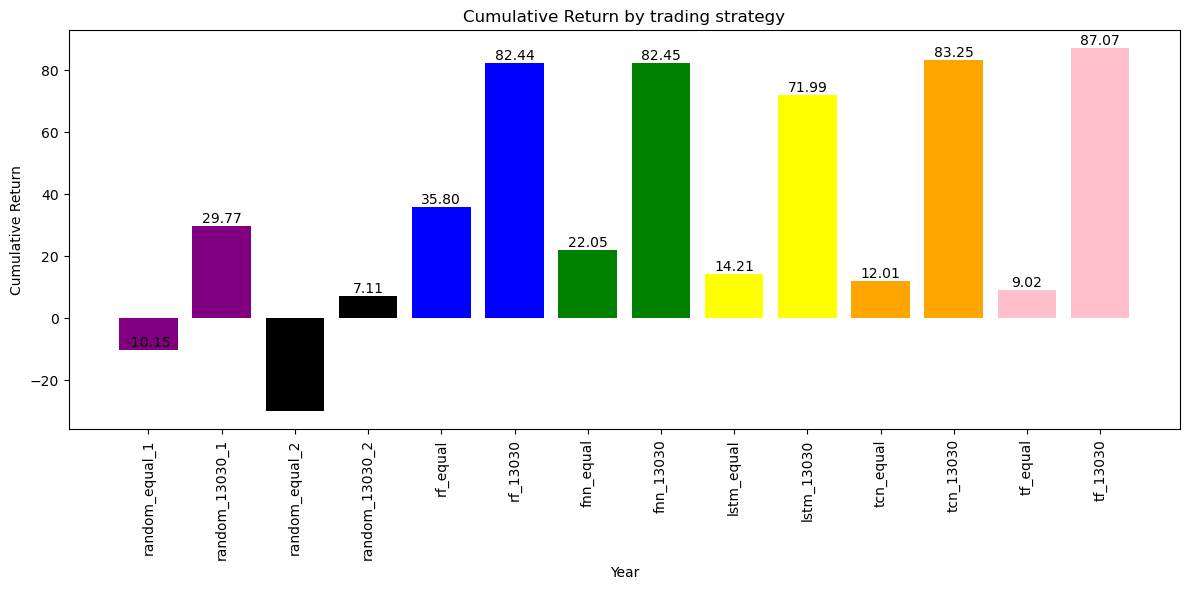

In [20]:
# test out different trading strategy

# cum return 

# for each model, read csv and add it to the dataframe
read_csv_dict={'rf_equal': 'rf_prediction_daily_return_summary_equal.csv'
             ,'rf_13030': 'rf_prediction_daily_return_summary_13030.csv'
            ,'fnn_equal': 'fnn_prediction_daily_return_summary_equal.csv'
            ,'fnn_13030': 'fnn_prediction_daily_return_summary_13030.csv'
            ,'lstm_equal': 'lstm_prediction_daily_return_summary_equal.csv'
            ,'lstm_13030': 'lstm_prediction_daily_return_summary_13030.csv'
            ,'tcn_equal': 'tcn_prediction_daily_return_summary_equal.csv'
            ,'tcn_13030': 'tcn_prediction_daily_return_summary_13030.csv'
            ,'tf_equal': 'tf_prediction_daily_return_summary_equal.csv'
            ,'tf_13030': 'tf_prediction_daily_return_summary_13030.csv'
              }

summary_return = pd.DataFrame()
for file, csv in read_csv_dict.items():
    mean_return = pd.read_csv(csv)
    mean_return.rename(columns={'Unnamed: 0':'date'}, inplace=True)
    mean_return = mean_return[mean_return['date']==max(mean_return['date'])]
    mean_return['model']=file
    mean_return = mean_return[['model','cum_return_no_cost']]
    summary_return = pd.concat([mean_return,summary_return])

#### random portofolio
file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-11-13')]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')

# Porfolio 1
portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    short_file['daily_return'] = (-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

portfolio_performance = portfolio.groupby(['Date'])['daily_return'].mean().reset_index()
portfolio_performance.rename(columns={'daily_return':'cum_return_no_cost'},inplace=True)
portfolio_performance = portfolio_performance['cum_return_no_cost'].cumsum().reset_index()
portfolio_performance['model']='random_equal_1'
portfolio_performance = portfolio_performance[-1:]
portfolio_performance = portfolio_performance[['model','cum_return_no_cost']]


file = pd.read_csv('stock_analysis.csv')
file = file[(file['Date']>='2012-12-03')  & (file['Date']<='2017-11-13') ]
file['Date'] =pd.to_datetime(file['Date'])
file['year_month'] = file.Date.dt.strftime('%y/%m')


# Portfolio2
portfolio2 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
longlist = file['Ticker'].sample(n=10, random_state=60).to_list()
shortlist = file['Ticker'].sample(n=10, random_state=25).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long]
    long_profit=pd.concat([long_file,long_profit])
for short in shortlist:
    short_file = file[file['Ticker']==short] 
    short_file['daily_return'] = (-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])
portfolio2 = pd.concat([long_profit, short_profit])    

portfolio_performance2  = portfolio2.groupby(['Date'])['daily_return'].mean().reset_index()
portfolio_performance2.rename(columns={'daily_return':'cum_return_no_cost'},inplace=True)
portfolio_performance2 = portfolio_performance2['cum_return_no_cost'].cumsum().reset_index()
portfolio_performance2['model']='random_equal_2'
portfolio_performance2 = portfolio_performance2[-1:]
portfolio_performance2 = portfolio_performance2[['model','cum_return_no_cost']]
portfolio_performance2


#### 130 30

portfolio = pd.DataFrame()
unique_date = file['Date'].unique()
for ud in unique_date:
    date_file = file[file['Date']==ud]
    long_file = date_file.sample(n=10, random_state=50) # 10 stocks as porfolio per day
    short_file = date_file.sample(n=10, random_state=0) # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    portfolio = pd.concat([portfolio,long_file, short_file])    

portfolio_performance3 = portfolio.groupby(['Date'])['daily_return'].mean().reset_index()
portfolio_performance3.rename(columns={'daily_return':'cum_return_no_cost'},inplace=True)
portfolio_performance3 = portfolio_performance3['cum_return_no_cost'].cumsum().reset_index()
portfolio_performance3['model']='random_13030_1'
portfolio_performance3 = portfolio_performance3[-1:]
portfolio_performance3 = portfolio_performance3[['model','cum_return_no_cost']]


# Portfolio4
portfolio4 = pd.DataFrame()
long_profit = pd.DataFrame()
short_profit= pd.DataFrame()
#longlist = file['Ticker'].sample(n=10, random_state=100).to_list()
#shortlist = file['Ticker'].sample(n=10, random_state=5).to_list()
for long in longlist:
    long_file = file[file['Ticker']==long] # 10 stocks as porfolio per day
    long_file['daily_return'] = (1.3)*long_file['daily_return']
    long_profit=pd.concat([long_file,long_profit])
for short in shortlist:
    short_file = file[file['Ticker']==short] # 10 stocks as porfolio per day
    short_file['daily_return'] = (0.3)*(-1)*short_file['daily_return']
    short_profit=pd.concat([short_file,short_profit])
portfolio4 = pd.concat([long_profit, short_profit])    

portfolio_performance4 = portfolio4.groupby(['Date'])['daily_return'].mean().reset_index()
portfolio_performance4.rename(columns={'daily_return':'cum_return_no_cost'},inplace=True)
portfolio_performance4 = portfolio_performance4['cum_return_no_cost'].cumsum().reset_index()
portfolio_performance4['model']='random_13030_2'
portfolio_performance4 = portfolio_performance4[-1:]
portfolio_performance4 = portfolio_performance4[['model','cum_return_no_cost']]
portfolio_performance4


summary_return =pd.concat([portfolio_performance, portfolio_performance2,
                           portfolio_performance3, portfolio_performance4, summary_return])

custom_sort = {'random_equal_1':0
    ,'random_13030_1':1
    ,'random_equal_2':2
    , 'random_13030_2':3
    , 'rf_equal': 4
    ,'rf_13030': 5
    ,'fnn_equal': 6
    ,'fnn_13030': 7
    ,'lstm_equal': 8
    ,'lstm_13030': 9
    ,'tcn_equal': 10
    ,'tcn_13030': 11
    ,'tf_equal': 12
    ,'tf_13030': 13}
summary_return = summary_return.sort_values(by=['model'], key = lambda x:x.map(custom_sort))


fig  =  plt.figure(figsize=(12,6))

#for column in df.columns:
#    plt.plot(summary_return[column],summary_return['cum_return_no_cost'])

color_label=['purple','purple','black', 'black'
             ,'blue','blue','green','green','yellow','yellow'
             ,'orange','orange','pink','pink'
            ]

bars = plt.bar(summary_return['model'], summary_return['cum_return_no_cost'], color=color_label)
for bar, value in zip(bars, summary_return['cum_return_no_cost']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.03, f'{value:.2f}', ha='center', va='bottom')

plt.title('Cumulative Return by trading strategy')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [21]:
mean_return = pd.read_csv('rf_prediction_daily_return_summary_equal.csv')
mean_return

,Unnamed: 0,daily_return_no_cost,cum_return_no_cost,daily_return_cost,cum_return_cost
0,2012-12-03,0.026297,1.026297,0.025797,1.025797
1,2012-12-04,-0.730599,0.295698,-0.731249,0.294548
2,2012-12-05,-0.524901,-0.229203,-0.525401,-0.230853
3,2012-12-06,-0.287398,-0.516602,-0.287848,-0.518702
4,2012-12-07,-0.539039,-1.055641,-0.539439,-1.058141
...,...,...,...,...,...
1244,2017-11-06,-0.613365,34.505394,-0.613965,33.790644
1245,2017-11-07,0.111118,34.616512,0.110518,33.901162
1246,2017-11-08,0.582794,35.199305,0.582094,34.483255
1247,2017-11-09,-0.484480,34.714826,-0.485030,33.998226


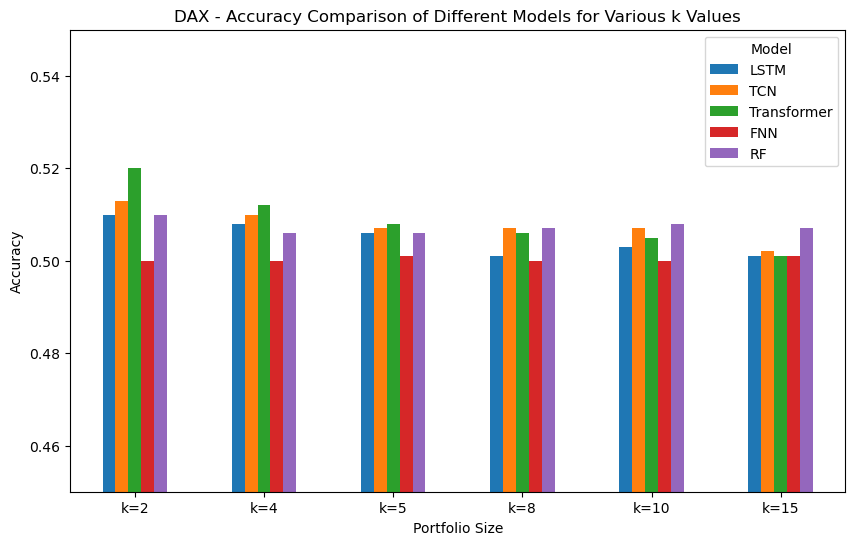

In [8]:
# Plotting
ax = dax_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.xlabel('Portfolio Size')
plt.ylabel('Accuracy')
plt.title('DAX - Accuracy Comparison of Different Models for Various k Values')
plt.legend(title='Model')
plt.ylim(0.45,0.55)

plt.savefig('DAXaccuracy.png')

plt.show()